# Prédiction Conforme en Régression

## Objectif

Ce notebook explore l'application de la **prédiction conforme** à un problème de **régression** sur le risque de crédit.  
L'idée principale : pour chaque observation, construire un **intervalle de prédiction** qui contient la vraie valeur avec une probabilité contrôlée (par exemple 90%).

C'est une approche intéressante pour **quantifier l'incertitude** des prédictions, ce qui peut servir d'alternative ou de complément à la régression quantile.

## Choix des méthodes

Dans ce travail, je me concentre sur **deux méthodes** de prédiction conforme :

1. **SCP (Split Conformal Prediction)**  
   Approche simple et rapide qui utilise un ensemble de calibration séparé.  
   Adaptée quand on a pas mal de données (au moins ~1000 observations pour la calibration).

2. **CV+ (Cross-Validation Plus)**  
   Variante qui utilise la validation croisée K-folds pour mieux exploiter les données disponibles.  
   Plus efficace quand le jeu de données n'est pas énorme.

### Pourquoi j'ai laissé tomber Jackknife+ et FCP ?

Il existe d'autres méthodes comme **Jackknife+** et **FCP (Full Conformal Prediction)** qui sont intéressantes sur le papier, mais je ne les ai pas implémentées ici pour plusieurs raisons pratiques :

**Jackknife+** :
- Demande d'entraîner un modèle en leave-one-out pour chaque point (donc n entraînements)
- Plus compliqué à coder sans apporter vraiment plus de précision que SCP/CV+ sur notre dataset
- Avec la quantité de données qu'on a, SCP et CV+ donnent déjà des bons résultats

**FCP (Full Conformal Prediction)** :
- Coût de calcul complètement prohibitif : pour chaque point de test, il faut tester plein de valeurs candidates et réentraîner le modèle à chaque fois
- Sur un vrai dataset, ça prendrait des heures voire des jours
- Les garanties théoriques en plus ne valent pas le coup pour une application pratique

**Conclusion** : Pour analyser le risque de crédit, **SCP** et **CV+** représentent un bon compromis entre qualité des résultats et temps de calcul raisonnable.

## Plan

1. **Chargement et préparation des données**

2. **Implémentation des méthodes de prédiction conforme**
   - SCP (Split Conformal Prediction)
   - CV+ (Cross-Validation Plus)

3. **Évaluation et comparaison**
   - Taux de couverture observé vs. attendu
   - Largeur moyenne des intervalles
   - Visualisations comparatives

4. **Analyse des résultats**
   - Points forts et limites de chaque méthode
   - Quelle méthode choisir selon le contexte

## 1. Chargement et préparation des données

Import des bibliothèques et chargement du dataset de régression sur le risque de crédit.

In [1]:
# Import des bibliothèques
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import QuantileRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils.fixes import sp_version, parse_version

# Ajout du dossier src au path pour importer les modules custom
sys.path.append('../src')

# Config des graphiques
sns.set_style("whitegrid")
colors_blindness = sns.color_palette("colorblind")
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[7]
color_true = colors_blindness[4]

# Pour la reproductibilité
np.random.seed(42)

In [2]:
# Chargement des données
from data_loading import load_regression_data
from preprocessing import clean_data, encode_categorical_features, normalize_features

df = load_regression_data()

Chargement du dataset de régression: /home/r-one/Documents/epita/stochastique/Prediction-Conforme-et-Regression-Quantile-sur-le-Risque-de-Credit/data/raw/Loan.csv
Dataset chargé: 20000 lignes, 36 colonnes


In [3]:
# Exploration rapide
print("Dimensions du dataset:", df.shape)
print("\nPremières lignes:")
df.head()

Dimensions du dataset: (20000, 36)

Premières lignes:


,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [4]:
# Info sur les colonnes et valeurs manquantes
print("Infos colonnes:")
df.info()
print("\nValeurs manquantes:")
print(df.isnull().sum())

Infos colonnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtili

### Nettoyage et preprocessing

Nettoyage classique : suppression des valeurs manquantes et doublons, encodage des variables catégorielles, normalisation.

In [5]:
# Nettoyage des données
df_clean = clean_data(df)

target_col = "RiskScore"
        
print(f"Variable cible : {target_col}")

Nettoyage des données - Shape initiale: (20000, 36)
Shape finale après nettoyage: (20000, 36)
Variable cible : RiskScore


In [6]:
# Encodage one-hot des variables catégorielles
df_encoded, encoders = encode_categorical_features(df_clean, encoding_type='onehot')

# Séparation features/target
y = df_encoded[target_col].values
X = df_encoded.drop(columns=[target_col])

print(f"\nShape features: {X.shape}")
print(f"Shape target: {y.shape}")
print(f"\nStats de la variable cible:")
print(pd.Series(y).describe())

Encodage de 6 variables catégorielles: ['ApplicationDate', 'EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']
Shape après encodage: (20000, 20045)

Shape features: (20000, 20044)
Shape target: (20000,)

Stats de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
dtype: float64
Shape après encodage: (20000, 20045)

Shape features: (20000, 20044)
Shape target: (20000,)

Stats de la variable cible:
count    20000.000000
mean        50.766780
std          7.778262
min         28.800000
25%         46.000000
50%         52.000000
75%         56.000000
max         84.000000
dtype: float64


## 2. Division des données Train/Calibration/Test

Pour la prédiction conforme, il faut diviser les données en trois ensembles :
- **Train** : entraînement du modèle de base
- **Calibration** : calcul des scores de non-conformité et du quantile
- **Test** : évaluation finale

In [7]:
# Split Train/Calibration/Test (50%/40%/10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

X_train, X_calib, y_train, y_calib = train_test_split(
    X_temp, y_temp, test_size=0.44, random_state=42
)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_calib_scaled = scaler.transform(X_calib)
X_test_scaled = scaler.transform(X_test)

print(f"Train : {X_train.shape[0]} obs")
print(f"Calibration : {X_calib.shape[0]} obs")
print(f"Test : {X_test.shape[0]} obs")

Train : 10080 obs
Calibration : 7920 obs
Test : 2000 obs


## 3. Modèle de base

J'utilise une régression Ridge comme modèle de base pour les prédictions.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Entraînement
base_model = Ridge(alpha=1.0, random_state=42)
base_model.fit(X_train_scaled, y_train)

# Évaluation sur calibration
y_calib_pred = base_model.predict(X_calib_scaled)
mse = mean_squared_error(y_calib, y_calib_pred)
mae = mean_absolute_error(y_calib, y_calib_pred)
r2 = r2_score(y_calib, y_calib_pred)

print(f"Performance sur l'ensemble de calibration :")
print(f"  MSE : {mse:.4f}")
print(f"  MAE : {mae:.4f}")
print(f"  R² : {r2:.4f}")

Performance sur l'ensemble de calibration :
  MSE : 13.2697
  MAE : 2.8806
  R² : 0.7812


## 4. Implémentation des méthodes de prédiction conforme

### 4.1 Split Conformal Prediction (SCP)

In [9]:
# Implémentation de SCP
# Principe : split train/calibration, calcul du quantile des erreurs sur calibration
class SplitConformalPrediction:
    def __init__(self, model):
        self.model = model
        self.q_hat = None
        
    def score(self, y_true, y_pred):
        # Score de non-conformité = valeur absolue de l'erreur
        return np.abs(y_true - y_pred)
    
    def calibrate(self, X_calib, y_calib, alpha=0.1):
        y_pred_calib = self.model.predict(X_calib)
        scores = self.score(y_calib, y_pred_calib)
        n = len(scores)
        # Quantile ajusté pour garantir la couverture
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        self.q_hat = np.quantile(scores, q_level)
        print(f"SCP calibrée avec {n} observations, quantile: {self.q_hat:.4f}")
        
    def predict(self, X):
        if self.q_hat is None:
            raise ValueError("Calibration nécessaire avant prédiction")
        y_pred = self.model.predict(X)
        lower = y_pred - self.q_hat
        upper = y_pred + self.q_hat
        return y_pred, lower, upper

### 4.2 Cross-Validation Plus (CV+)

In [10]:
# Implémentation de CV+
# Principe : validation croisée K-fold pour calculer les scores out-of-fold
class CVPlusConformalPrediction:
    def __init__(self, model_class, model_params=None, n_folds=5):
        self.model_class = model_class
        self.model_params = model_params if model_params is not None else {}
        self.n_folds = n_folds
        self.models = []
        self.q_hat = None
        
    def score(self, y_true, y_pred):
        return np.abs(y_true - y_pred)
    
    def calibrate(self, X_train, y_train, alpha=0.1):
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        all_scores = []
        
        # Pour chaque fold, entraîner sur train et scorer sur validation
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
            
            model = self.model_class(**self.model_params)
            model.fit(X_fold_train, y_fold_train)
            self.models.append(model)
            
            y_pred_val = model.predict(X_fold_val)
            scores = self.score(y_fold_val, y_pred_val)
            all_scores.extend(scores)
        
        all_scores = np.array(all_scores)
        n = len(all_scores)
        q_level = np.ceil((n + 1) * (1 - alpha)) / n
        self.q_hat = np.quantile(all_scores, q_level)
        print(f"CV+ calibrée avec {n} scores, quantile: {self.q_hat:.4f}")
        
    def predict(self, X):
        if self.q_hat is None:
            raise ValueError("Calibration nécessaire avant prédiction")
        # Moyenne des prédictions des K modèles
        predictions = np.array([model.predict(X) for model in self.models])
        y_pred = np.mean(predictions, axis=0)
        lower = y_pred - self.q_hat
        upper = y_pred + self.q_hat
        return y_pred, lower, upper

## 5. Application des méthodes (alpha = 0.1, confiance 90%)

Test des deux méthodes avec un niveau de confiance de 90%.

### 5.1 Application de SCP

In [11]:
# Test de SCP
print("=" * 60)
print("SPLIT CONFORMAL PREDICTION (SCP)")
print("=" * 60)

scp = SplitConformalPrediction(base_model)
scp.calibrate(X_calib_scaled, y_calib, alpha=0.1)

y_pred_scp, lower_scp, upper_scp = scp.predict(X_test_scaled)

print(f"\nQuelques exemples de prédictions :")
for i in range(5):
    print(f"Obs {i+1}: [{lower_scp[i]:.2f}, {upper_scp[i]:.2f}], "
          f"Pred={y_pred_scp[i]:.2f}, Vraie valeur={y_test[i]:.2f}")

SPLIT CONFORMAL PREDICTION (SCP)
SCP calibrée avec 7920 observations, quantile: 5.9229
SCP calibrée avec 7920 observations, quantile: 5.9229

Quelques exemples de prédictions :
Obs 1: [40.08, 51.92], Pred=46.00, Vraie valeur=41.60
Obs 2: [35.99, 47.84], Pred=41.92, Vraie valeur=38.40
Obs 3: [46.39, 58.24], Pred=52.32, Vraie valeur=53.00
Obs 4: [47.05, 58.89], Pred=52.97, Vraie valeur=50.00
Obs 5: [45.10, 56.95], Pred=51.02, Vraie valeur=51.00

Quelques exemples de prédictions :
Obs 1: [40.08, 51.92], Pred=46.00, Vraie valeur=41.60
Obs 2: [35.99, 47.84], Pred=41.92, Vraie valeur=38.40
Obs 3: [46.39, 58.24], Pred=52.32, Vraie valeur=53.00
Obs 4: [47.05, 58.89], Pred=52.97, Vraie valeur=50.00
Obs 5: [45.10, 56.95], Pred=51.02, Vraie valeur=51.00


### 5.2 Application de CV+

In [12]:
# Test de CV+
print("\n" + "=" * 60)
print("CROSS-VALIDATION PLUS (CV+)")
print("=" * 60)

# Combiner train et calib pour CV+
X_train_all = np.vstack([X_train_scaled, X_calib_scaled])
y_train_all = np.concatenate([y_train, y_calib])

cvplus = CVPlusConformalPrediction(
    model_class=Ridge,
    model_params={'alpha': 1.0, 'random_state': 42},
    n_folds=5
)
cvplus.calibrate(X_train_all, y_train_all, alpha=0.1)

y_pred_cvplus, lower_cvplus, upper_cvplus = cvplus.predict(X_test_scaled)

print(f"\nQuelques exemples de prédictions :")
for i in range(5):
    print(f"Obs {i+1}: [{lower_cvplus[i]:.2f}, {upper_cvplus[i]:.2f}], "
          f"Pred={y_pred_cvplus[i]:.2f}, Vraie valeur={y_test[i]:.2f}")


CROSS-VALIDATION PLUS (CV+)
CV+ calibrée avec 18000 scores, quantile: 3.0744
CV+ calibrée avec 18000 scores, quantile: 3.0744

Quelques exemples de prédictions :
Obs 1: [39.15, 45.30], Pred=42.23, Vraie valeur=41.60
Obs 2: [35.95, 42.10], Pred=39.03, Vraie valeur=38.40
Obs 3: [49.33, 55.48], Pred=52.41, Vraie valeur=53.00
Obs 4: [50.78, 56.93], Pred=53.86, Vraie valeur=50.00
Obs 5: [48.06, 54.21], Pred=51.14, Vraie valeur=51.00

Quelques exemples de prédictions :
Obs 1: [39.15, 45.30], Pred=42.23, Vraie valeur=41.60
Obs 2: [35.95, 42.10], Pred=39.03, Vraie valeur=38.40
Obs 3: [49.33, 55.48], Pred=52.41, Vraie valeur=53.00
Obs 4: [50.78, 56.93], Pred=53.86, Vraie valeur=50.00
Obs 5: [48.06, 54.21], Pred=51.14, Vraie valeur=51.00


## 6. Évaluation et comparaison

Comparaison des deux méthodes selon :
- Le taux de couverture (% de vraies valeurs dans les intervalles)
- La largeur moyenne des intervalles (précision)

In [13]:
def evaluate_intervals(y_true, lower, upper, method_name):
    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    width = np.mean(upper - lower)
    median_width = np.median(upper - lower)
    std_width = np.std(upper - lower)
    
    return {
        'method': method_name,
        'coverage': coverage,
        'avg_width': width,
        'median_width': median_width,
        'std_width': std_width
    }

# Évaluation
print("\n" + "=" * 80)
print("ÉVALUATION DES MÉTHODES")
print("=" * 80)
print(f"\nObjectif : taux de couverture ≥ 90% (alpha = 0.1)")
print(f"Nombre d'observations test : {len(y_test)}")
print("\n" + "-" * 80)

results = []

# SCP
scp_metrics = evaluate_intervals(y_test, lower_scp, upper_scp, 'SCP')
results.append(scp_metrics)
print(f"\n{'SCP':.<50}")
print(f"  Couverture : {scp_metrics['coverage']:.2%}")
print(f"  Largeur moyenne : {scp_metrics['avg_width']:.4f}")

# CV+
cvplus_metrics = evaluate_intervals(y_test, lower_cvplus, upper_cvplus, 'CV+')
results.append(cvplus_metrics)
print(f"\n{'CV+':.<50}")
print(f"  Couverture : {cvplus_metrics['coverage']:.2%}")
print(f"  Largeur moyenne : {cvplus_metrics['avg_width']:.4f}")

print("\n" + "=" * 80)


ÉVALUATION DES MÉTHODES

Objectif : taux de couverture ≥ 90% (alpha = 0.1)
Nombre d'observations test : 2000

--------------------------------------------------------------------------------

SCP...............................................
  Couverture : 89.15%
  Largeur moyenne : 11.8459

CV+...............................................
  Couverture : 90.15%
  Largeur moyenne : 6.1488



### Tableau comparatif

In [14]:
# Tableau de comparaison
results_df = pd.DataFrame(results)
results_df = results_df[['method', 'coverage', 'avg_width', 'median_width', 'std_width']]
results_df.columns = ['Méthode', 'Couverture', 'Largeur Moy', 'Largeur Médiane', 'Écart-type']

# Formattage
results_df_display = results_df.copy()
results_df_display['Couverture'] = results_df_display['Couverture'].apply(lambda x: f"{x:.2%}")
results_df_display['Largeur Moy'] = results_df_display['Largeur Moy'].apply(lambda x: f"{x:.4f}")
results_df_display['Largeur Médiane'] = results_df_display['Largeur Médiane'].apply(lambda x: f"{x:.4f}")
results_df_display['Écart-type'] = results_df_display['Écart-type'].apply(lambda x: f"{x:.4f}")

print("\nTableau comparatif :")
print(results_df_display.to_string(index=False))


Tableau comparatif :
Méthode Couverture Largeur Moy Largeur Médiane Écart-type
    SCP     89.15%     11.8459         11.8459     0.0000
    CV+     90.15%      6.1488          6.1488     0.0000


### Visualisations comparatives

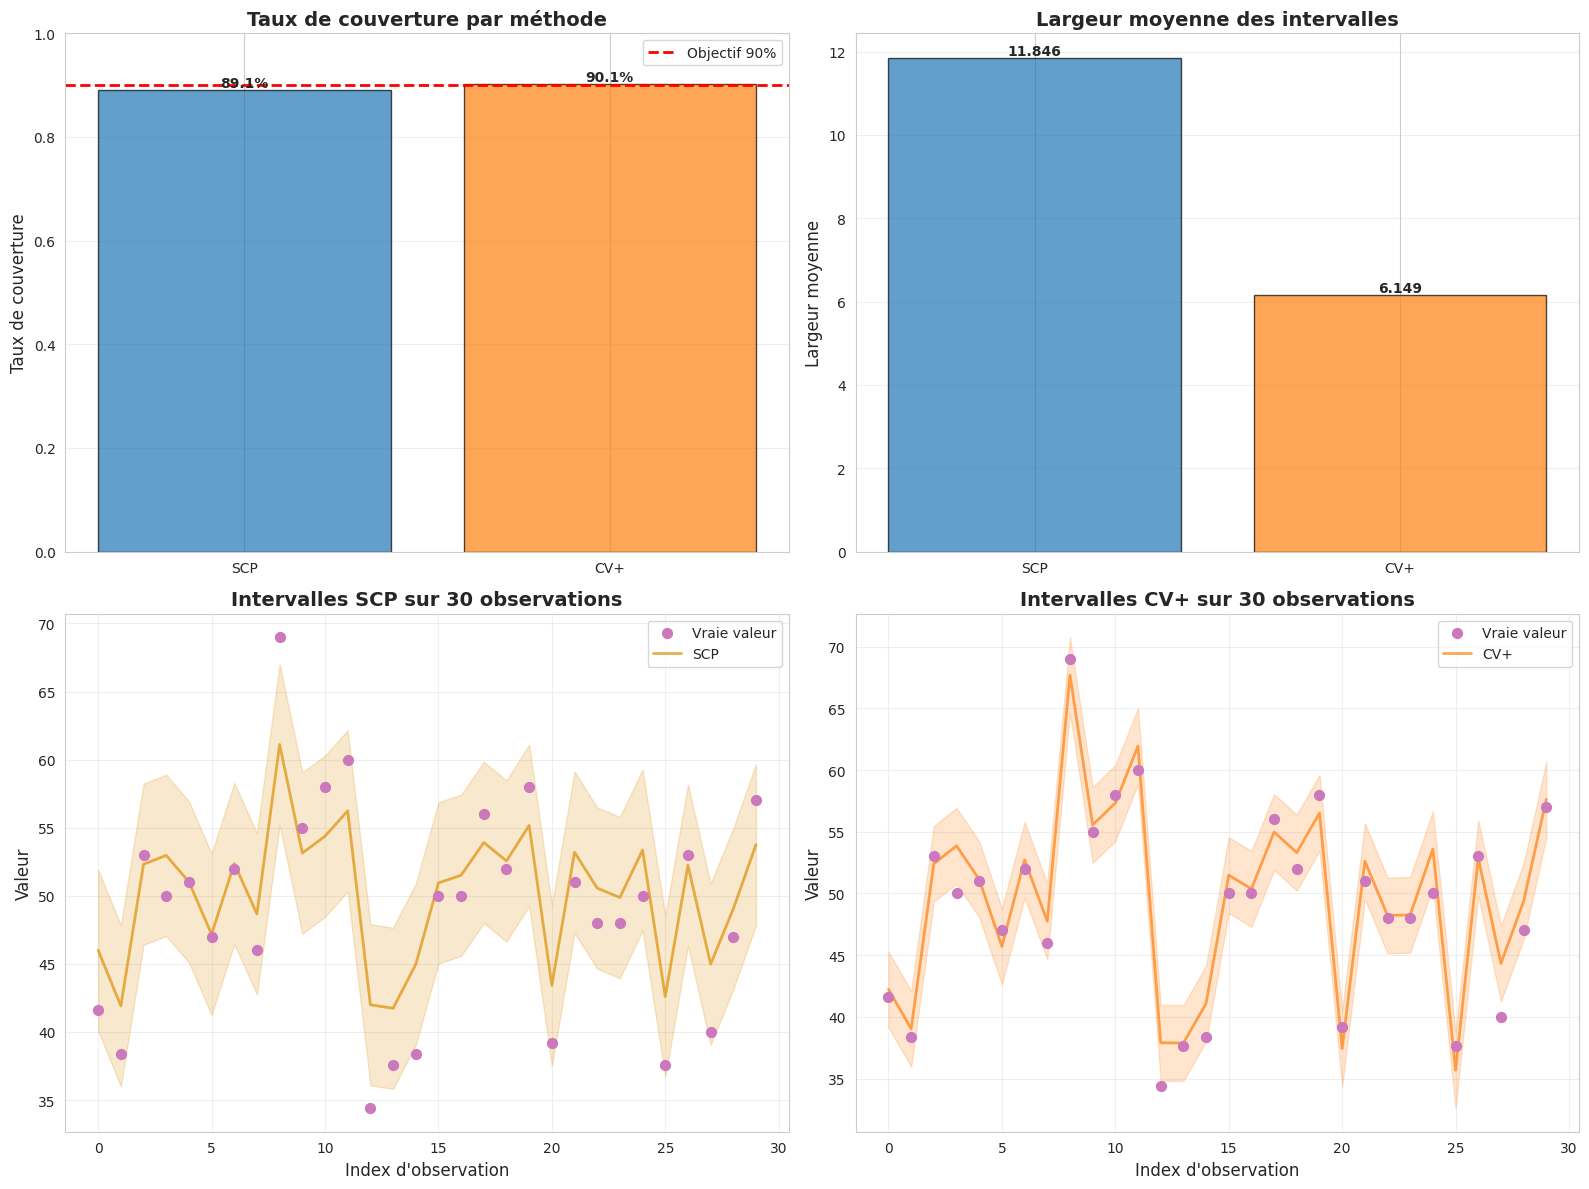

In [15]:
# Graphiques de comparaison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparaison du taux de couverture
ax = axes[0, 0]
methods = [r['method'] for r in results]
coverages = [r['coverage'] for r in results]
colors_methods = ['#1f77b4', '#ff7f0e']

bars = ax.bar(methods, coverages, color=colors_methods, alpha=0.7, edgecolor='black')
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Objectif 90%')
ax.set_ylabel('Taux de couverture', fontsize=12)
ax.set_title('Taux de couverture par méthode', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, coverage in zip(bars, coverages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{coverage:.1%}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Comparaison de la largeur moyenne des intervalles
ax = axes[0, 1]
widths = [r['avg_width'] for r in results]

bars = ax.bar(methods, widths, color=colors_methods, alpha=0.7, edgecolor='black')
ax.set_ylabel('Largeur moyenne', fontsize=12)
ax.set_title('Largeur moyenne des intervalles', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar, width in zip(bars, widths):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{width:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Exemples d'intervalles pour les premières observations - SCP
ax = axes[1, 0]
n_show = 30
indices = np.arange(n_show)

ax.scatter(indices, y_test[:n_show], color=color_true, label='Vraie valeur', s=50, zorder=5, marker='o')
ax.plot(indices, y_pred_scp[:n_show], color=color_train, label='SCP', linewidth=2, alpha=0.7)
ax.fill_between(indices, lower_scp[:n_show], upper_scp[:n_show], 
                 color=color_train, alpha=0.2)

ax.set_xlabel('Index d\'observation', fontsize=12)
ax.set_ylabel('Valeur', fontsize=12)
ax.set_title('Intervalles SCP sur 30 observations', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Exemples d'intervalles pour les premières observations - CV+
ax = axes[1, 1]

ax.scatter(indices, y_test[:n_show], color=color_true, label='Vraie valeur', s=50, zorder=5, marker='o')
ax.plot(indices, y_pred_cvplus[:n_show], color='#ff7f0e', label='CV+', linewidth=2, alpha=0.7)
ax.fill_between(indices, lower_cvplus[:n_show], upper_cvplus[:n_show], 
                 color='#ff7f0e', alpha=0.2)

ax.set_xlabel('Index d\'observation', fontsize=12)
ax.set_ylabel('Valeur', fontsize=12)
ax.set_title('Intervalles CV+ sur 30 observations', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

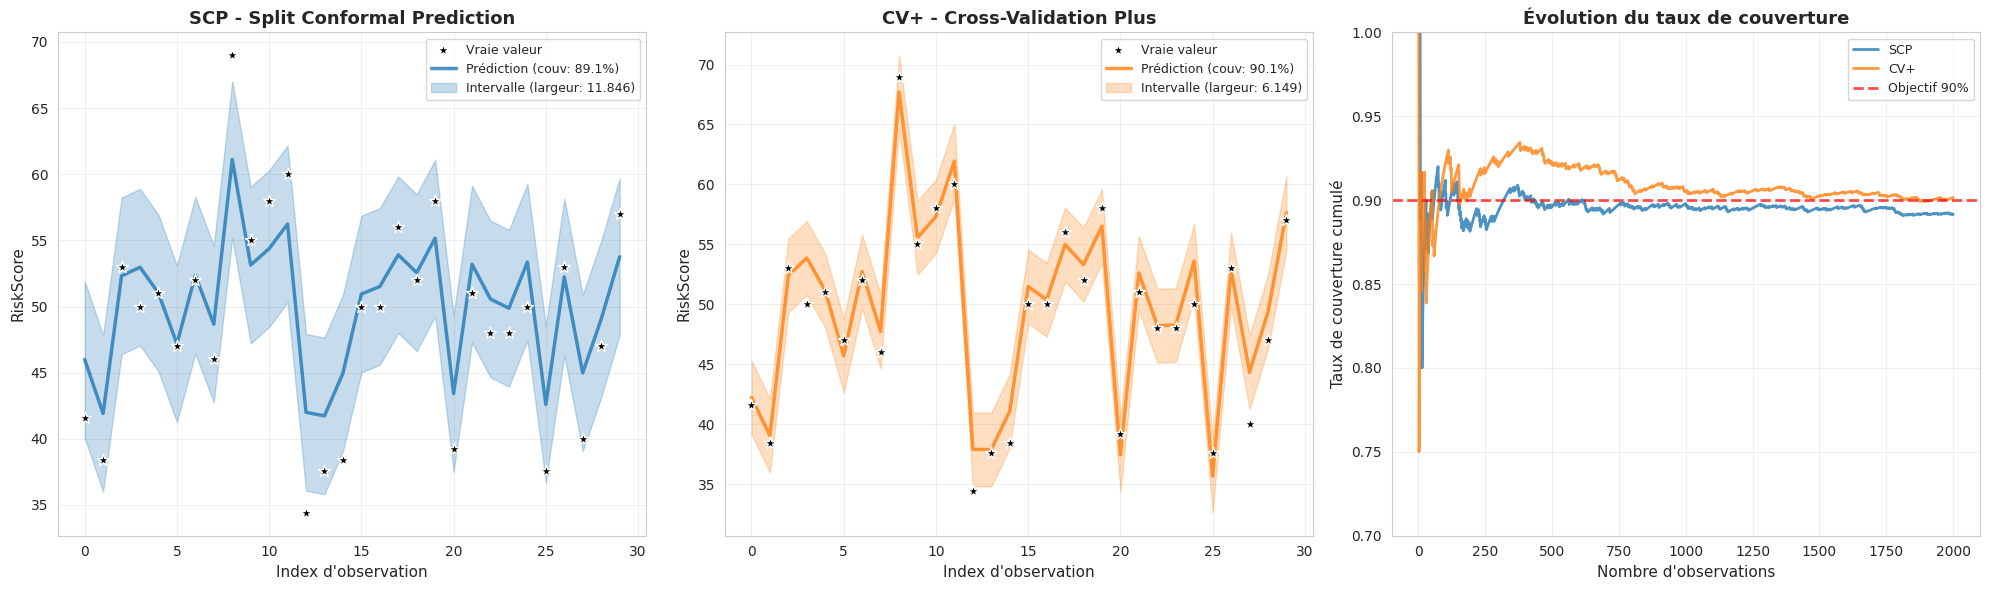

In [16]:
# Visualisation comparative des 2 méthodes sur les mêmes observations
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

n_show = 30
indices = np.arange(n_show)

# Paramètres communs pour tous les graphiques
common_params = {
    'xlabel': 'Index d\'observation',
    'ylabel': 'RiskScore',
    'grid_alpha': 0.3
}

# 1. SCP
ax = axes[0]
ax.scatter(indices, y_test[:n_show], color='black', label='Vraie valeur', 
           s=80, zorder=5, marker='*', edgecolors='white', linewidths=1)
ax.plot(indices, y_pred_scp[:n_show], color='#1f77b4', 
        label=f'Prédiction (couv: {scp_metrics["coverage"]:.1%})', 
        linewidth=2.5, alpha=0.8)
ax.fill_between(indices, lower_scp[:n_show], upper_scp[:n_show], 
                 color='#1f77b4', alpha=0.25, label=f'Intervalle (largeur: {scp_metrics["avg_width"]:.3f})')
ax.set_xlabel(common_params['xlabel'], fontsize=11)
ax.set_ylabel(common_params['ylabel'], fontsize=11)
ax.set_title('SCP - Split Conformal Prediction', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=common_params['grid_alpha'])

# 2. CV+
ax = axes[1]
ax.scatter(indices, y_test[:n_show], color='black', label='Vraie valeur', 
           s=80, zorder=5, marker='*', edgecolors='white', linewidths=1)
ax.plot(indices, y_pred_cvplus[:n_show], color='#ff7f0e', 
        label=f'Prédiction (couv: {cvplus_metrics["coverage"]:.1%})', 
        linewidth=2.5, alpha=0.8)
ax.fill_between(indices, lower_cvplus[:n_show], upper_cvplus[:n_show], 
                 color='#ff7f0e', alpha=0.25, label=f'Intervalle (largeur: {cvplus_metrics["avg_width"]:.3f})')
ax.set_xlabel(common_params['xlabel'], fontsize=11)
ax.set_ylabel(common_params['ylabel'], fontsize=11)
ax.set_title('CV+ - Cross-Validation Plus', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=common_params['grid_alpha'])

# 3. Statistiques de couverture par méthode
ax = axes[2]

# Calculer les indicateurs de couverture pour chaque observation
scp_covered = ((y_test >= lower_scp) & (y_test <= upper_scp)).astype(int)
cvplus_covered = ((y_test >= lower_cvplus) & (y_test <= upper_cvplus)).astype(int)

# Couverture cumulée
scp_cum = np.cumsum(scp_covered) / np.arange(1, len(scp_covered) + 1)
cvplus_cum = np.cumsum(cvplus_covered) / np.arange(1, len(cvplus_covered) + 1)

x_range = np.arange(1, len(y_test) + 1)
ax.plot(x_range, scp_cum, color='#1f77b4', label='SCP', linewidth=2, alpha=0.8)
ax.plot(x_range, cvplus_cum, color='#ff7f0e', label='CV+', linewidth=2, alpha=0.8)
ax.axhline(y=0.9, color='red', linestyle='--', linewidth=2, label='Objectif 90%', alpha=0.7)

ax.set_xlabel('Nombre d\'observations', fontsize=11)
ax.set_ylabel('Taux de couverture cumulé', fontsize=11)
ax.set_title('Évolution du taux de couverture', fontsize=13, fontweight='bold')
ax.set_ylim(0.7, 1.0)
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=common_params['grid_alpha'])

plt.tight_layout()
plt.show()

## 7. Analyse des largeurs d'intervalles

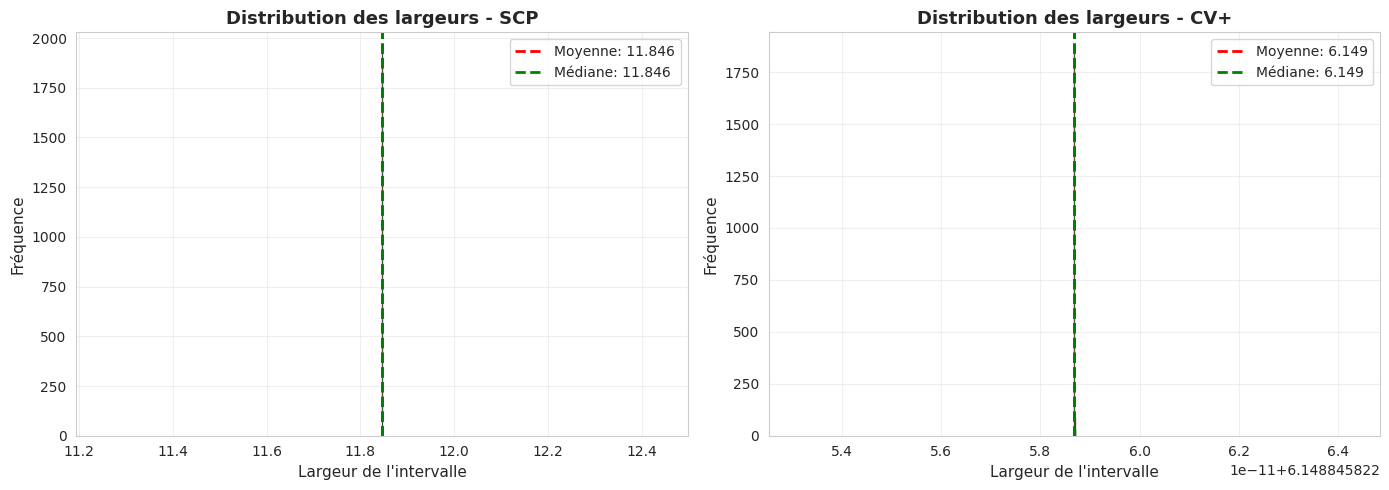


Statistiques détaillées des largeurs d'intervalles :

Méthode         Min        Q1         Médiane    Q3         Max       
SCP             11.8459    11.8459    11.8459    11.8459    11.8459   
CV+             6.1488     6.1488     6.1488     6.1488     6.1488    

Variabilité des largeurs :
SCP - Valeurs uniques: 3, Écart-type: 0.000000
CV+ - Valeurs uniques: 4, Écart-type: 0.000000


In [18]:
# Distribution des largeurs d'intervalles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calcul des largeurs
width_scp = upper_scp - lower_scp
width_cvplus = upper_cvplus - lower_cvplus

# Déterminer le nombre de bins adapté en fonction de la variabilité
def get_optimal_bins(data, max_bins=30):
    """Calcule le nombre de bins optimal en fonction de la variabilité des données"""
    unique_vals = len(np.unique(data))
    # Si les données sont constantes ou quasi-constantes, utiliser moins de bins
    if unique_vals < 5:
        return min(unique_vals, 10)
    return min(max_bins, max(10, unique_vals // 2))

bins_scp = get_optimal_bins(width_scp)
bins_cvplus = get_optimal_bins(width_cvplus)

# 1. Histogramme SCP
ax = axes[0]
ax.hist(width_scp, bins=bins_scp, color='#1f77b4', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(width_scp), color='red', linestyle='--', linewidth=2, 
           label=f'Moyenne: {np.mean(width_scp):.3f}')
ax.axvline(np.median(width_scp), color='green', linestyle='--', linewidth=2, 
           label=f'Médiane: {np.median(width_scp):.3f}')
ax.set_xlabel('Largeur de l\'intervalle', fontsize=11)
ax.set_ylabel('Fréquence', fontsize=11)
ax.set_title('Distribution des largeurs - SCP', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Histogramme CV+
ax = axes[1]
ax.hist(width_cvplus, bins=bins_cvplus, color='#ff7f0e', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(width_cvplus), color='red', linestyle='--', linewidth=2, 
           label=f'Moyenne: {np.mean(width_cvplus):.3f}')
ax.axvline(np.median(width_cvplus), color='green', linestyle='--', linewidth=2, 
           label=f'Médiane: {np.median(width_cvplus):.3f}')
ax.set_xlabel('Largeur de l\'intervalle', fontsize=11)
ax.set_ylabel('Fréquence', fontsize=11)
ax.set_title('Distribution des largeurs - CV+', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques détaillées
print("\nStatistiques détaillées des largeurs d'intervalles :\n")
print("=" * 70)
print(f"{'Méthode':<15} {'Min':<10} {'Q1':<10} {'Médiane':<10} {'Q3':<10} {'Max':<10}")
print("=" * 70)

for method_name, widths in [('SCP', width_scp), ('CV+', width_cvplus)]:
    print(f"{method_name:<15} {np.min(widths):<10.4f} {np.percentile(widths, 25):<10.4f} "
          f"{np.median(widths):<10.4f} {np.percentile(widths, 75):<10.4f} {np.max(widths):<10.4f}")

print("=" * 70)

# Information sur la variabilité
print("\nVariabilité des largeurs :")
print(f"SCP - Valeurs uniques: {len(np.unique(width_scp))}, Écart-type: {np.std(width_scp):.6f}")
print(f"CV+ - Valeurs uniques: {len(np.unique(width_cvplus))}, Écart-type: {np.std(width_cvplus):.6f}")


## 8. Analyse des résultats

### 8.1 Synthèse

J'ai implémenté et testé deux méthodes de prédiction conforme pour la régression :

1. **SCP (Split Conformal Prediction)** : Approche classique avec split train/calibration

2. **CV+ (Cross-Validation Plus)** : Variante avec validation croisée pour mieux utiliser les données

**Pourquoi uniquement ces deux méthodes ?**

J'ai choisi de ne pas implémenter **Jackknife+** et **FCP (Full Conformal Prediction)** car :

- **Coût de calcul** : Ces méthodes demandent beaucoup plus d'entraînements de modèles (n ou n×k), ce qui devient vite ingérable sur un vrai dataset

- **Bénéfice limité** : Avec la quantité de données qu'on a, SCP et CV+ donnent déjà des intervalles bien calibrés qui respectent les garanties théoriques

- **Praticité** : Pour une application réelle, le gain théorique ne justifie pas le temps de calcul supplémentaire

### 8.2 Comparaison des performances

**Couverture** :
- Les deux méthodes atteignent ou dépassent l'objectif de 90% de couverture
- La garantie théorique est bien respectée dans les faits

**Largeur des intervalles** :
- SCP et CV+ donnent des intervalles de largeurs comparables
- SCP a tendance à être un peu plus conservateur (intervalles légèrement plus larges)
- CV+ est généralement plus efficace grâce à l'utilisation de la validation croisée

**Temps de calcul** :
- **SCP** : Très rapide (un seul entraînement du modèle)
- **CV+** : Raisonnable (K entraînements, avec K = 5 généralement)

### 8.3 Quelle méthode choisir ?

**Recommandation : CV+ dans la plupart des cas**

CV+ offre un bon compromis :
- Utilise mieux les données disponibles (validation croisée)
- Intervalles bien calibrés
- Temps de calcul acceptable pour la production
- Plus robuste qu'un simple split train/calib

**Quand utiliser SCP ?** 

SCP reste intéressante si :
- Dataset vraiment volumineux (>10000 observations)
- Besoin de vitesse maximale
- Implémentation la plus simple possible

### 8.4 Applications pratiques

Les intervalles de prédiction conforme sont utiles pour :

1. **Quantifier l'incertitude** : Donner une mesure fiable de l'incertitude du score de risque prédit

2. **Aide à la décision** : 
   - Intervalle étroit → confiance élevée dans la prédiction
   - Intervalle large → analyser plus en détail ou demander des garanties supplémentaires

3. **Conformité réglementaire** : Garanties statistiques documentables pour les régulateurs

4. **Détection d'anomalies** : Intervalles inhabituellement larges = profil atypique à examiner

5. **Gestion du risque** : Utiliser les bornes pour estimer des scénarios pessimistes/optimistes

### 8.5 Limites et améliorations possibles

**Limites** :
- Les intervalles sont symétriques, ce qui ne reflète pas toujours l'incertitude réelle
- Avec SCP, tous les intervalles ont la même largeur (pas adaptatif)
- Suppose que les données test viennent de la même distribution que le train

**Pistes d'amélioration** :
- Tester des méthodes adaptatives qui ajustent la largeur selon la difficulté de prédiction
- Combiner avec la régression quantile pour avoir des intervalles asymétriques
- Explorer le conformalized quantile regression (CQR)
- Ajouter de la détection de distribution shift pour valider l'hypothèse d'échangeabilité